<a href="https://colab.research.google.com/github/Fidelisaboke/adversarial-machine-learning/blob/main/fgsm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Gradient Sign Method on Fashion MNIST Dataset
## Reference Resources
- [FGSM on MNIST Fashion Dataset](https://medium.com/berkeleyischool/fgsm-attacks-on-mnist-fashion-dataset-90cd0eeed7ab)
- [Adversarial Example using FGSM](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)


## What is FGSM?
- FGSM is a single-step, white-box technique used to generate adversarial examples by scaling the sign of the loss function's gradient with respect to the original input.
- By doing this, it **maximizes** the loss function.
- A small perturbation it taken to modify the example in such a way that it is
somewhat similar to the original, but has a great impact on the model's predictions.

## Importing Required Libraries

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Loading the Data

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Normalize the Data

In [3]:
# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test /255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


## Visualize the Data

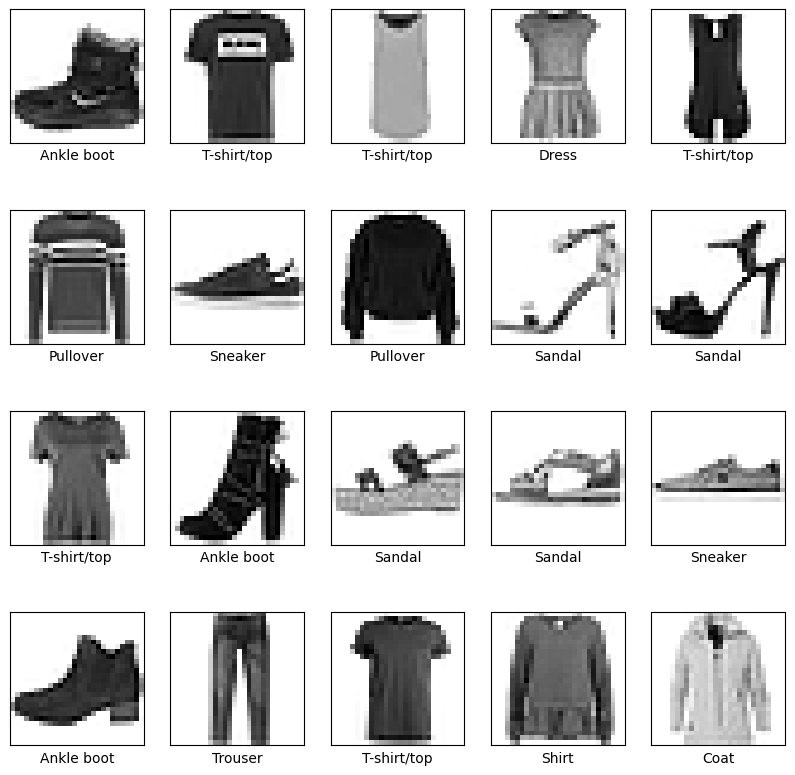

In [5]:
# Class Names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
]

plt.figure(figsize=(10, 10))
for i in range(0, 20):
  plt.subplot(4, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[y_train[i]])
plt.show()

## Define the FGSM function

In [17]:
def fgsm(model, data, epsilon):
  """Apply FGSM to the model. Epsilon controls perturbation strength."""
  # Convert inputs and labels to a tensor
  inputs, labels = data
  inputs = tf.convert_to_tensor(inputs)
  labels = tf.convert_to_tensor(labels)

  with tf.GradientTape() as tape:
    tape.watch(inputs)
    predictions = model(inputs)
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)
    loss = loss_fn(labels, predictions)

  # Compute the gradient of the loss w.r.t the inputs
  gradient = tape.gradient(loss, inputs)

  # Get the sign of the gradients of the loss w.r.t input images
  signed_grad = tf.sign(gradient)

  # Generate adversarial examples
  perturbed_inputs = inputs + epsilon * signed_grad

  # Clip to ensure values are within [0, 1]
  perturbed_inputs = tf.clip_by_value(perturbed_inputs, 0, 1)

  return perturbed_inputs



## Training a Basic CNN

In [14]:
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10)
])

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)



Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.7919 - loss: 0.6056 - val_accuracy: 0.8718 - val_loss: 0.3568
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8918 - loss: 0.3078 - val_accuracy: 0.9027 - val_loss: 0.2811
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9077 - loss: 0.2588 - val_accuracy: 0.9042 - val_loss: 0.2731


## Attacking the CNN

In [19]:
sample_batch = (X_test[:100], y_test[:100])
adv_examples = fgsm(model, sample_batch, epsilon=0.1)

# Compare model predictions
original_predicitons = tf.argmax(model(sample_batch[0]), axis=1)
adversarial_predicitons = tf.argmax(model(adv_examples), axis=1)

# Accuracy drop
accuracy = tf.reduce_mean(tf.cast(original_predicitons == sample_batch[1], tf.float32))
adversarial_accuracy = tf.reduce_mean(tf.cast(adversarial_predicitons == sample_batch[1], tf.float32))

print(f'Original Accuracy: {accuracy}')
print(f'Adversarial Accuracy: {adversarial_accuracy}')



Original Accuracy: 0.8799999952316284
Adversarial Accuracy: 0.18000000715255737


## Accuracy vs. Epsilon Curve

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_fgsm_accuracy_vs_epsilon(model, data, epsilons, num_samples=1000):
    """Evaluate model accuracy on adversarial examples generated with varying epsilons."""
    inputs, labels = data
    inputs = tf.convert_to_tensor(inputs[:num_samples])
    labels = tf.convert_to_tensor(labels[:num_samples], dtype=tf.int64)


    clean_preds = tf.argmax(model(inputs), axis=1)
    clean_acc = tf.reduce_mean(tf.cast(clean_preds == labels, tf.float32)).numpy()

    adv_accuracies = []

    for eps in epsilons:
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = model(inputs)
            loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            loss = loss_fn(labels, predictions)

        gradients = tape.gradient(loss, inputs)
        signed_grad = tf.sign(gradients)
        adv_inputs = tf.clip_by_value(inputs + eps * signed_grad, 0, 1)

        adv_preds = tf.argmax(model(adv_inputs), axis=1)
        adv_acc = tf.reduce_mean(tf.cast(adv_preds == labels, tf.float32)).numpy()
        adv_accuracies.append(adv_acc)

    return clean_acc, adv_accuracies

def plot_accuracy_vs_epsilon(epsilons, clean_acc, adv_accuracies):
    """Plot model accuracy vs epsilon."""
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, adv_accuracies, marker='o', label='Adversarial Accuracy')
    plt.axhline(clean_acc, color='green', linestyle='--', label='Clean Accuracy')
    plt.title("Model Accuracy vs FGSM Epsilon")
    plt.xlabel("Epsilon (perturbation strength)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


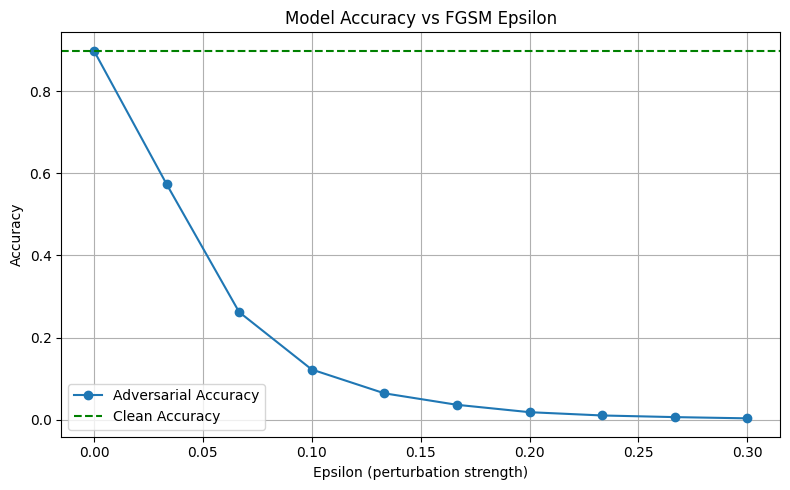

In [25]:
# Define epsilon values
epsilons = np.linspace(0, 0.3, 10)

# Run evaluation
clean_acc, adv_accuracies = evaluate_fgsm_accuracy_vs_epsilon(
    model, (X_test, y_test), epsilons, num_samples=1000
)

# Plot
plot_accuracy_vs_epsilon(epsilons, clean_acc, adv_accuracies)
